In [ ]:
#Topic trending analysis
# This script loads pre-computed BERTopic data and merges it with patent metadata.
# It filters out noise topics and outputs a DataFrame with relevant information.
import os
import pickle
import numpy as np
import pandas as pd

# 1. Set up loading paths
base_dir   = r"E:\Waterloo-onedrive\OneDrive - University of Waterloo\MSE 641"
save_dir   = os.path.join(base_dir, "BERTopic model")
input_path = os.path.join(base_dir, "Merged Data", "Merged_data_ML.csv")

doc_ids_path     = os.path.join(save_dir, "doc_ids.pkl")          # Document ID
topics_path = os.path.join(save_dir, "topics.pkl")      # Document → topic_id
probs_path       = os.path.join(save_dir, "probs.npy")            # Probability matrix
topic_info_path  = os.path.join(save_dir, "topic_info.csv")   

# 2. Load the orginal patent metadata
df_ml = pd.read_csv(
    input_path,
    parse_dates=['pub_dt'],
    dtype={'assignee_type': str}   
)

# Transform 'assignee_type' to numeric, handling errors
df_ml['assignee_type'] = pd.to_numeric(df_ml['assignee_type'].str.strip(), errors='coerce')
before, df_ml = len(df_ml), df_ml.dropna(subset=['assignee_type'])
print(f"⚠️ Drop {before - len(df_ml)} useless assignee_type records")
df_ml['assignee_type'] = df_ml['assignee_type'].astype(int)

# 3. Load pre-computed data
with open(doc_ids_path, 'rb') as f:
    doc_ids = pickle.load(f)

with open(topics_path, 'rb') as f:
    topics = pickle.load(f)          # list, the number of topics = the number of documents

probs = np.load(probs_path)  

# 4. Build a DataFrame for sentences
sent_df = pd.DataFrame({
    'doc_id': doc_ids,
    'topic_id': topics,
    'max_prob': [row.max() for row in probs]
})
# Filter out noise topics (topic_id = -1)
sent_df = sent_df[sent_df.topic_id != -1] 

# 5. Relate sentences to documents
merged = sent_df.join(
    df_ml[['pub_dt', 'assignee_type']],
    on='doc_id'
)
merged['year'] = merged['pub_dt'].dt.year

topic_info = pd.read_csv(topic_info_path, encoding='utf-8-sig')   
merged = merged.merge(
    topic_info[['Topic', 'polished_name', 'confidence']],
    left_on='topic_id', right_on='Topic',
    how='left'
).drop(columns='Topic').rename(columns={'polished_name': 'topic_name'})

# Filter out topics that are not readable
merged = merged[merged['confidence'] == 'high'].copy()

# 6. Output sample data
print(merged.head())
assignee_map = {
    1: 'Unassigned',
    2: 'US Company or Corporation',
    3: 'Foreign Company or Corporation',
    4: 'US Individual',
    5: 'Foreign Individual',
    6: 'US Federal Government',
    7: 'Foreign Government',
    8: 'US County Government',
    9: 'US State Government'
}
merged['assignee_desc'] = merged['assignee_type'].map(assignee_map)
merged['year'] = merged['pub_dt'].dt.year


C:\Users\Yue Qiao\AppData\Local\Temp\ipykernel_24788\1028730911.py:17: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ml = pd.read_csv(


⚠️ 丢弃 4 行无效 assignee_type
    doc_id  topic_id  max_prob     pub_dt  assignee_type    year  \
3        0       119  0.000000 2018-06-19            2.0  2018.0   
10       2        11  0.000000 2018-06-19            2.0  2018.0   
11       2        11  0.000000 2018-06-19            2.0  2018.0   
17       3        82  0.000000 2018-06-19            3.0  2018.0   
19       3        20  0.795108 2018-06-19            3.0  2018.0   

                              topic_name confidence  
3                Time‑Series Forecasting       high  
10                    Autonomous Driving       high  
11                    Autonomous Driving       high  
17  Semiconductor Wafer Layout Metrology       high  
19              Graph Edge‑Node Analysis       high  


In [ ]:
# 7. Do the summary according to year, assignee type, and topic
agg = (
    merged
    .groupby(['year', 'assignee_desc', 'topic_id', 'topic_name'], as_index=False)
    .agg(
        doc_count = ('topic_id',  'size'),   # Count of documents in each topic
        prob_sum  = ('max_prob',  'sum')     # Sum of probabilities for each topic
    )
)
# 8. Get the top 5 topics for each year and assignee type
top5 = (
    agg
    .sort_values(['year', 'assignee_desc', 'prob_sum'],
                 ascending=[True, True, False])
    .groupby(['year', 'assignee_desc'], as_index=False)
    .head(5)      
    .reset_index(drop=True)
)

print("Each year Assignee Type Top-5 hot topics：")
print(top5)
# 9. Save the result to a CSV file
trend_dir = r"E:\Waterloo-onedrive\OneDrive - University of Waterloo\MSE 641\Trend Analysis"
os.makedirs(trend_dir, exist_ok=True)
output_path = os.path.join(trend_dir, "top5_trends_by_year_assignee.csv")
top5.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"✅ Top-5 trends are saved to：{output_path}")


Each year Assignee Type Top-5 hot topics：
       year                   assignee_desc  topic_id  \
0    2015.0  Foreign Company or Corporation         1   
1    2015.0  Foreign Company or Corporation         2   
2    2015.0  Foreign Company or Corporation        11   
3    2015.0  Foreign Company or Corporation        20   
4    2015.0  Foreign Company or Corporation        51   
..      ...                             ...       ...   
273  2023.0                   US Individual         2   
274  2023.0                   US Individual        67   
275  2023.0                   US Individual        32   
276  2023.0                   US Individual        41   
277  2023.0                   US Individual        17   

                           topic_name  doc_count   prob_sum  
0    Image Segmentation / Point Cloud        163  60.598134  
1    Computer‑Readable Storage Medium        111  51.689451  
2                  Autonomous Driving         51  22.839590  
3            Graph Edge‑N

In [ ]:
# Summary of trends across all years and assignee types
# 10. Aggregate data across all years and assignee types
agg_total = (
    merged
    .groupby(['year', 'topic_id', 'topic_name'], as_index=False)
    .agg(
        doc_count = ('topic_id', 'size'),
        prob_sum  = ('max_prob', 'sum')
    )
)

# Top 10 topics for each year
top10_total = (
    agg_total
    .sort_values(['year', 'prob_sum'], ascending=[True, False])
    .groupby('year', as_index=False)
    .head(10)                    
    .reset_index(drop=True)
)

print("Top 10 hot topics for each year：")
print(top10_total.head(20))

# 11. Save the results
trend_dir = r"E:\Waterloo-onedrive\OneDrive - University of Waterloo\MSE 641\Trend Analysis"
os.makedirs(trend_dir, exist_ok=True)

out_total = os.path.join(trend_dir, "top10_trends_by_year_overall.csv")
top10_total.to_csv(out_total, index=False, encoding="utf-8-sig")
print(f"✅ The year trend is saved to：{out_total}")


Top 10 hot topics for each year：
      year  topic_id                            topic_name  doc_count  \
0   2015.0         1      Image Segmentation / Point Cloud        567   
1   2015.0         2      Computer‑Readable Storage Medium        513   
2   2015.0        38           Search Query Result Ranking        723   
3   2015.0        11                    Autonomous Driving        199   
4   2015.0        13                 Neural Network Layers        141   
5   2015.0        17             Outlier Anomaly Detection        113   
6   2015.0        30  Battery and Combustion Power Systems        110   
7   2015.0        20              Graph Edge‑Node Analysis        196   
8   2015.0        32       Spiking Neural Synapse Modeling        153   
9   2015.0        42           Search Query Result Ranking        205   
10  2016.0         2      Computer‑Readable Storage Medium        591   
11  2016.0         1      Image Segmentation / Point Cloud        602   
12  2016.0        

C:\Users\Yue Qiao\AppData\Local\Temp\ipykernel_24788\2047212504.py:11: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


   year  total_patents
0  2015           4566
1  2016           4995
2  2017           5285
3  2018           5507
4  2019           8964
   year  assignee_type  doc_count
0  2015              2       3477
1  2015              3       1032
2  2015              4         10
3  2015              5          9
4  2015              6         23


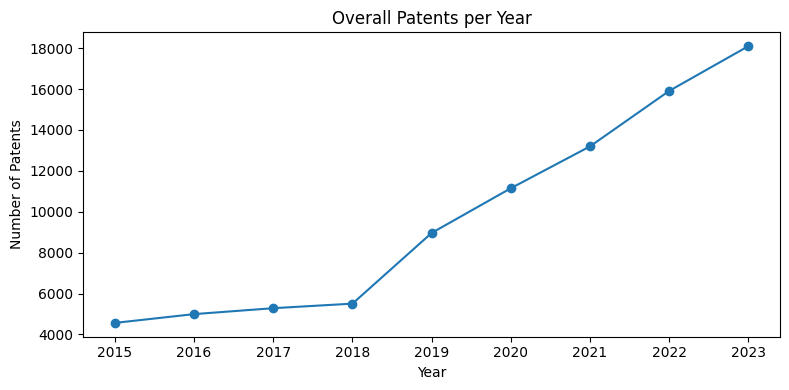

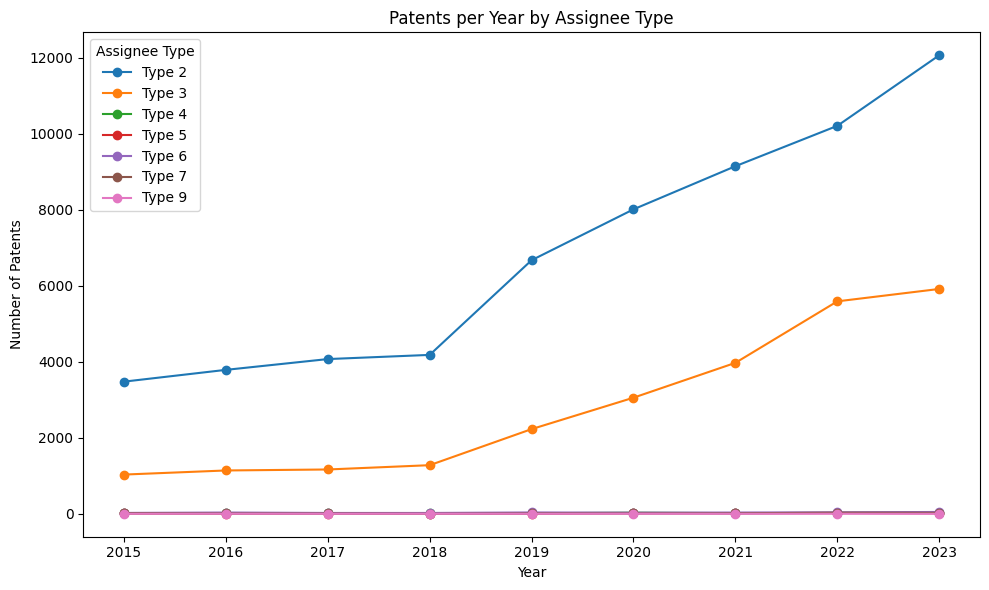

✅ 完成整体和按类型的年度统计，并已将图表和 CSV 保存到： E:\Waterloo-onedrive\OneDrive - University of Waterloo\MSE 641\Trend Analysis


In [ ]:
# Descriptive statistics for each year's patents
import os
import pandas as pd
import matplotlib.pyplot as plt


# 1. Load the data and clean the assignee_type
base_dir   = r"E:\Waterloo-onedrive\OneDrive - University of Waterloo\MSE 641"
save_dir   = os.path.join(base_dir, "BERTopic model")
input_path = os.path.join(base_dir, "Merged Data", "Merged_data_ML.csv")
df = pd.read_csv(
    input_path, # The dataset path used here is the Mergerd patent data
    parse_dates=['pub_dt'],
    dtype={'assignee_type': str}
)
# 2. Transform 'assignee_type' to numeric, handling errors
df['assignee_type'] = pd.to_numeric(df['assignee_type'].str.strip(), errors='coerce')
df = df.dropna(subset=['assignee_type']).copy()
df['assignee_type'] = df['assignee_type'].astype(int)

# 3. Extract year from publication date
df['year'] = df['pub_dt'].dt.year

# 4. Whole patent number statistics
total_per_year = (
    df
    .groupby('year')['pub_dt']
    .count()
    .reset_index(name='total_patents')
    .sort_values('year')
)
print(total_per_year.head())

# 5. Group by year and assignee type
type_per_year = (
    df
    .groupby(['year', 'assignee_type'])
    .size()
    .reset_index(name='doc_count')
    .sort_values(['year', 'assignee_type'])
)
print(type_per_year.head())

# 6. Plotting trends
# 6.1 Overall trend
plt.figure(figsize=(8, 4))
plt.plot(total_per_year['year'], total_per_year['total_patents'], marker='o')
plt.title('Overall Patents per Year')
plt.xlabel('Year')
plt.ylabel('Number of Patents')
plt.tight_layout()
plt.savefig(os.path.join(trend_dir, 'overall_patents_per_year.png'))
plt.show()

# 6.2 Trend by assignee type
pivot = type_per_year.pivot(index='year', columns='assignee_type', values='doc_count').fillna(0)

plt.figure(figsize=(10, 6))
for t in pivot.columns:
    plt.plot(pivot.index, pivot[t], marker='o', label=f'Type {t}')
plt.title('Patents per Year by Assignee Type')
plt.xlabel('Year')
plt.ylabel('Number of Patents')
plt.legend(title='Assignee Type', loc='best')
plt.tight_layout()
plt.savefig(os.path.join(trend_dir, 'patents_by_type_per_year.png'))
plt.show()

# 7. Save the results to CSV files and png files
total_per_year.to_csv(os.path.join(trend_dir, 'total_patents_per_year.csv'),
                      index=False, encoding='utf-8-sig')
type_per_year.to_csv(os.path.join(trend_dir, 'patents_by_type_per_year.csv'),
                     index=False, encoding='utf-8-sig')

print("Statistics finished，both csv and png files are saved to：", trend_dir)


In [ ]:
# Descriptive statistics for each topic's proportion in patents per year

# 1. Statistics for each year's total patent count
total_per_year = (
    merged
    .groupby('year')['doc_id']
    .count()
    .reset_index(name='total_docs')
)

# 2. Count documents per year and topic
year_topic_count = (
    merged
    .groupby(['year', 'topic_id', 'topic_name'])['doc_id']
    .count()
    .reset_index(name='doc_count')
)

# 3. Count each topic's proportion in patents per year
year_topic_prop = (
    year_topic_count
    .merge(total_per_year, on='year')
    .assign(prop=lambda df: df['doc_count'] / df['total_docs'])
)

# Statistics for each topic's proportion in patents per year
topic_prop_stats = (
    year_topic_prop
    .groupby(['topic_id', 'topic_name'], as_index=False)
    .agg(
        prop_mean=('prop', 'mean'),
        prop_std =('prop', 'std'),
        prop_min =('prop', 'min'),
        prop_max =('prop', 'max')
    )
    .sort_values('prop_mean', ascending=False)
)

# 5. Save the results
print("Mean value, standard deviation, min/max value of each topic's proportion：")
print(topic_prop_stats.head(10))

# output_stats = os.path.join(trend_dir, "topic_prop_stats.csv")
# topic_prop_stats.to_csv(output_stats, index=False, encoding='utf-8-sig')
# print(f"The topic proportion is saved to：{output_stats}")


每个主题占比的均值、标准差、最小/最大值：
    topic_id                        topic_name  prop_mean  prop_std  prop_min  \
0          1  Image Segmentation / Point Cloud   0.064125  0.003581  0.060032   
1          2  Computer‑Readable Storage Medium   0.061317  0.004394  0.056232   
17        38       Search Query Result Ranking   0.042478  0.021579  0.019014   
2         11                Autonomous Driving   0.031200  0.007415  0.021636   
3         13             Neural Network Layers   0.028234  0.011932  0.015455   
19        41           Social Networking Media   0.026745  0.011699  0.011707   
9         24       Performance Testing Metrics   0.025276  0.002344  0.020498   
6         20          Graph Edge‑Node Analysis   0.022454  0.001984  0.020648   
23        47     Feature Vector Representation   0.022252  0.002436  0.017977   
30        56           Question‑Answering (QA)   0.019363  0.005585  0.012080   

    prop_max  
0   0.069335  
1   0.067849  
17  0.079250  
2   0.041548  
3   0.04621

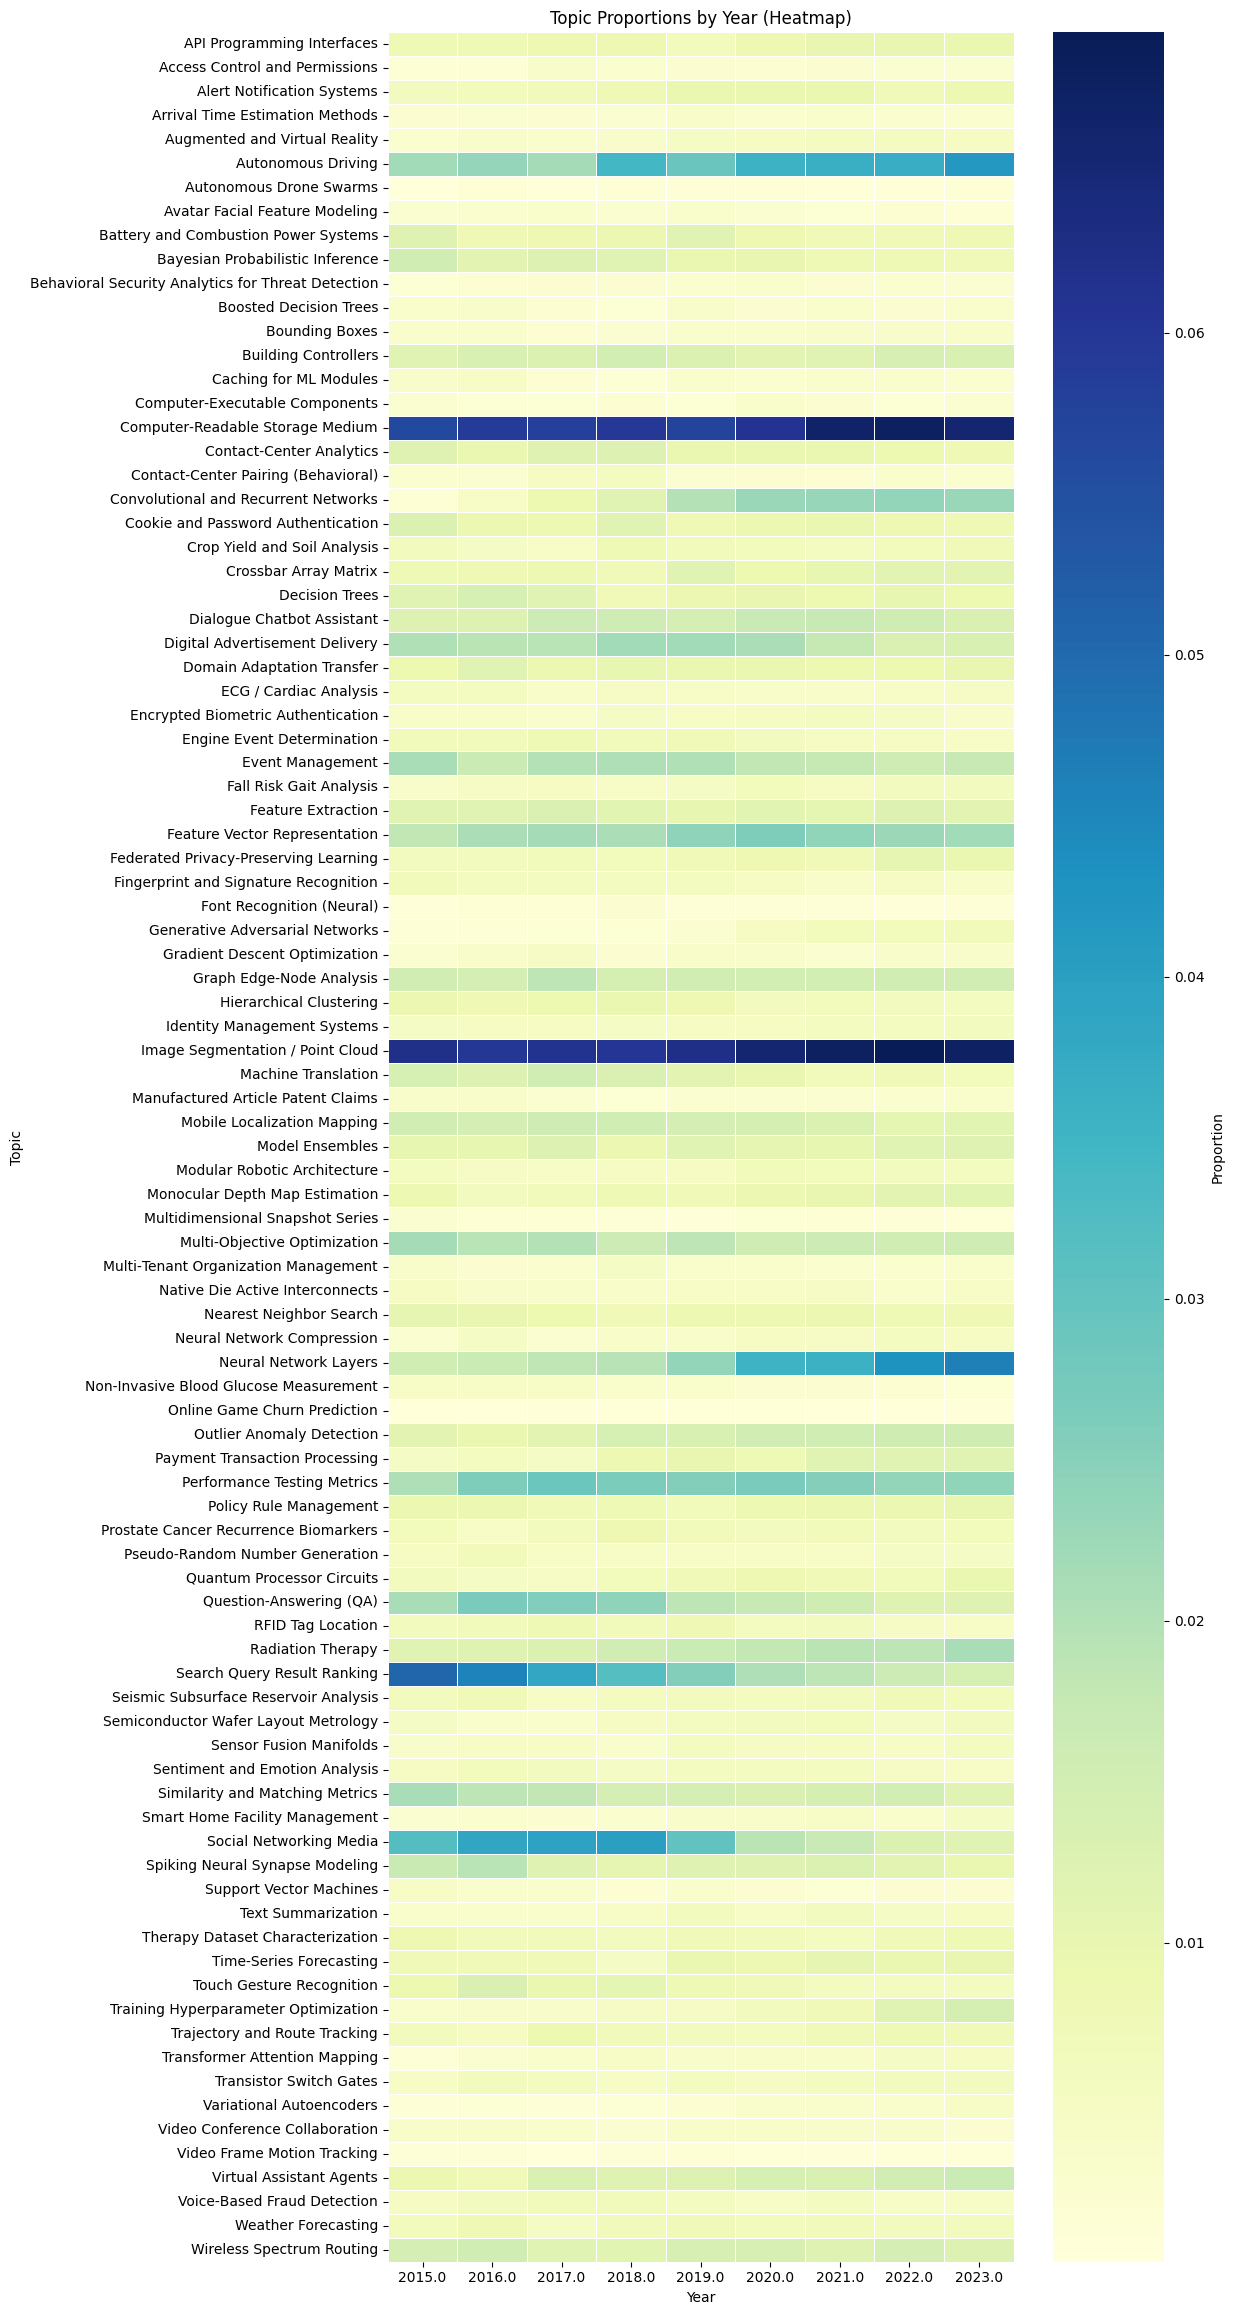

In [ ]:
# Visualize the topic proportions by year using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 1. Using the pivot_table method to create a heatmap DataFrame
heatmap_df = year_topic_prop.pivot_table(
    index='topic_name',
    columns='year',
    values='prop',
    aggfunc='mean'
).fillna(0)

# 2. Visualize the heatmap
plt.figure(figsize=(12, max(6, len(heatmap_df)*0.25)))
sns.heatmap(
    heatmap_df, 
    cmap='YlGnBu', 
    linewidths=0.5,
    cbar_kws={'label': 'Proportion'}
)
plt.title('Topic Proportions by Year (Heatmap)')
plt.xlabel('Year')
plt.ylabel('Topic')
plt.tight_layout()

# 3. Save the heatmap
output_path = os.path.join(trend_dir, 'topic_prop_heatmap.png')
plt.savefig(output_path)
plt.show()


In [ ]:
# Calculate the Compound Annual Growth Rate (CAGR) for each topic

#1. Count the number of documents per year and topic
year_topic_count = (
    merged
    .groupby(['year', 'topic_id', 'topic_name'], as_index=False)
    .agg(doc_count=('doc_id', 'count'))
)

# 2. Set the start and end years
year_min = year_topic_count['year'].min()
year_max = year_topic_count['year'].max()
n_periods = year_max - year_min  # 年数间隔

# 3. Get the start and end counts for each topic
start = year_topic_count[year_topic_count['year'] == year_min][['topic_id','doc_count']].rename(columns={'doc_count':'start_count'})
end   = year_topic_count[year_topic_count['year'] == year_max][['topic_id','doc_count']].rename(columns={'doc_count':'end_count'})

# 4. Calculate CAGR = (end/start)^(1/n_periods) - 1
growth = (
    start
    .merge(end, on='topic_id')
    .assign(
        CAGR=lambda df: (df['end_count'] / df['start_count']) ** (1 / n_periods) - 1
    )
)

#5. Supplement topic_name, and select the top 10
topic_names = year_topic_count[['topic_id','topic_name']].drop_duplicates()
top10_growth = (
    growth
    .merge(topic_names, on='topic_id')
    .sort_values('CAGR', ascending=False)
    .head(10)
    .loc[:, ['topic_id','topic_name','start_count','end_count','CAGR']]
)

# 6. Save the results
print("The top 10 topics with the highest CAGR：")
print(top10_growth)

# top10_growth.to_csv(
#     os.path.join(trend_dir, 'top10_topics_by_CAGR.csv'),
#     index=False,
#     encoding='utf-8-sig'
# )
# print("The result is saved to：", os.path.join(trend_dir, 'top10_topics_by_CAGR.csv'))


📈 增长最快的 10 个主题：
     topic_id                            topic_name  start_count  end_count  \
5          19  Convolutional and Recurrent Networks           13        860   
31         61       Generative Adversarial Networks           10        250   
63        106         Transformer Attention Mapping           10        192   
10         26  Training Hyperparameter Optimization           30        535   
76        135              Variational Autoencoders            9        157   
102       197               Autonomous Drone Swarms            3         46   
3          13                 Neural Network Layers          141       1733   
92        163          Online Game Churn Prediction            2         22   
64        107                Policy Rule Management           35        384   
69        117        Payment Transaction Processing           44        440   

         CAGR  
5    0.688766  
31   0.495349  
63   0.446814  
10   0.433521  
76   0.429576  
102  0.406710  
3 

In [ ]:
# Trend and role analysis by topic and assignee type

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import os

# 1. Load the original data and merged DataFrame 
base_dir   = r"E:\Waterloo-onedrive\OneDrive - University of Waterloo\MSE 641"
save_dir   = os.path.join(base_dir, "BERTopic model")
input_path = os.path.join(base_dir, "Merged Data", "Merged_data_ML.csv")

df_ml = pd.read_csv(
    input_path,
    parse_dates=['pub_dt'],
    dtype={'assignee_type': str},
)
# 2. Clean the assignee_type
df_ml['assignee_type'] = pd.to_numeric(df_ml['assignee_type'].str.strip(), errors='coerce')
df_ml = df_ml.dropna(subset=['assignee_type'])
df_ml['assignee_type'] = df_ml['assignee_type'].astype(int)

# 3. Load pre-computed data from BERTopic model
with open(os.path.join(save_dir, "doc_ids.pkl"), 'rb') as f:
    doc_ids = pickle.load(f)
with open(os.path.join(save_dir, "topics.pkl"), 'rb') as f:
    topics = pickle.load(f)
probs = np.load(os.path.join(save_dir, "probs.npy"))

# 4. Build a DataFrame for sentences
sent_df = pd.DataFrame({
    'doc_id': doc_ids,
    'topic_id': topics,
    'max_prob': [row.max() for row in probs]
})
sent_df = sent_df[sent_df.topic_id != -1]          # Remove noise topics
merged = sent_df.join(
    df_ml[['pub_dt','assignee_type']],
    on='doc_id'
)
merged['year'] = merged['pub_dt'].dt.year

# 5. Add topic_name and filter for high confidence topics
topic_info = pd.read_csv(os.path.join(save_dir, "topic_info.csv"), encoding='utf-8-sig')
merged = merged.merge(
    topic_info[['Topic','polished_name','confidence']],
    left_on='topic_id', right_on='Topic',
    how='left'
)
merged = merged[merged['confidence']=='high'].copy()
merged = merged.drop(columns=['Topic']).rename(columns={'polished_name':'topic_name'})


# 6. Load the embeddings and map them to the merged DataFrame
emb_path   = os.path.join(base_dir, "Embeddings", "embeddings.npy")
embeddings = np.load(emb_path)
emb_map = dict(zip(df_ml.index, embeddings))
merged['emb'] = merged['doc_id'].map(emb_map)

# 7. Compute centroids and roles
topic_year_centroids = (
    merged
    .groupby(['year','topic_name'])['emb']
    .apply(lambda vs: np.mean(np.stack(vs.values), axis=0))
)

#8. Compute the centroids for each topic and assignee type * each year
assignee_topic_centroids = (
    merged
    .groupby(['year','topic_name','assignee_type'])['emb']
    .apply(lambda vs: np.mean(np.stack(vs.values), axis=0))
)

# 9. Calculate similarity between assignee type centroids and topic centroids
rows = []
for (year, topic, desc), vec in assignee_topic_centroids.items():
    gc = topic_year_centroids.loc[(year, topic)]
    sim = float(cosine_similarity(vec.reshape(1, -1), gc.reshape(1, -1))[0,0])
    rows.append({'year': year, 'topic_name': topic,
                 'assignee_type': desc, 'sim': sim})
roles_df = pd.DataFrame(rows)

# 10. Divide the Leader/Follower/Laggard based on quantiles
def assign_role(subdf):
    q1, q3 = subdf['sim'].quantile([0.25,0.75])
    subdf['role'] = subdf['sim'].apply(
        lambda x: 'Leader' if x>=q3 else ('Laggard' if x<=q1 else 'Follower')
    )
    return subdf
roles_df = roles_df.groupby(['year','topic_name'], group_keys=False).apply(assign_role)

# 11. Save the roles DataFrame
print(roles_df.head())
roles_df.to_csv(os.path.join(base_dir, "Trend Analysis", "roles_by_topic.csv"), index=False)

# 12. Calculate the overall trend: count and proportion of each role per year
overall_by_topic = (
    roles_df
    .groupby(['year','topic_name','role'])
    .size()
    .reset_index(name='count')
)

totals = (
    overall_by_topic
    .groupby(['year','topic_name'])['count']
    .sum()
    .rename('total')
    .reset_index()
)
overall_by_topic = (
    overall_by_topic
    .merge(totals, on=['year','topic_name'])
)
overall_by_topic['prop'] = overall_by_topic['count'] / overall_by_topic['total']
overall_by_topic.to_csv(
    os.path.join(trend_dir, 'overall_role_trend_by_topic.csv'),
    index=False
)

# 13. Calculate the proportion of each role by assignee type
type_trend_by_topic = (
    roles_df
    .groupby(['year','topic_name','assignee_type','role'])
    .size()
    .reset_index(name='count')
)

topic_totals = (
    type_trend_by_topic
    .groupby(['year','topic_name'])['count']
    .sum()
    .rename('topic_total')
    .reset_index()
)
type_trend_by_topic = (
    type_trend_by_topic
    .merge(topic_totals, on=['year','topic_name'])
)
type_trend_by_topic['prop'] = type_trend_by_topic['count'] / type_trend_by_topic['topic_total']
type_trend_by_topic.to_csv(
    os.path.join(trend_dir, 'type_role_trend_by_topic.csv'),
    index=False
)

print("Role trend is saved to：")
print("overall_role_trend.csv（Overall Leader/Follower/Laggard Proportion）")
print("type_role_trend.csv（Each assignee_type Proportion）")


C:\Users\Yue Qiao\AppData\Local\Temp\ipykernel_24788\4028902758.py:18: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ml = pd.read_csv(


     year                      topic_name  assignee_type       sim      role
0  2015.0      API Programming Interfaces            2.0  0.995570    Leader
1  2015.0      API Programming Interfaces            3.0  0.927605  Follower
2  2015.0      API Programming Interfaces            7.0  0.555211   Laggard
3  2015.0  Access Control and Permissions            2.0  0.990872    Leader
4  2015.0  Access Control and Permissions            3.0  0.793554   Laggard
✅ 角色趋势已保存到：
   - overall_role_trend.csv（总体 Leader/Follower/Laggard 占比）
   - type_role_trend.csv（各 assignee_type 的角色占比）


C:\Users\Yue Qiao\AppData\Local\Temp\ipykernel_24788\4028902758.py:96: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  roles_df = roles_df.groupby(['year','topic_name'], group_keys=False).apply(assign_role)


C:\Users\Yue Qiao\AppData\Local\Temp\ipykernel_24788\1740472295.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')


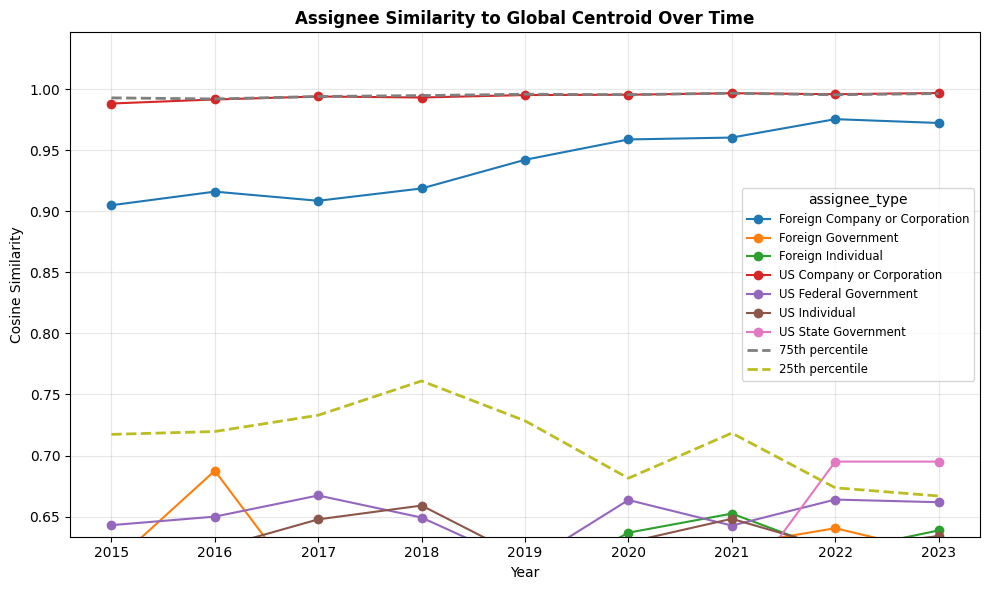

✅ Plot saved to: E:\Waterloo-onedrive\OneDrive - University of Waterloo\MSE 641\Trend Analysis\sim_trend_by_type.png


In [ ]:
# Plotting the similarity trends by assignee type
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Assignee type mapping dictionary
assignee_map = {
    1: 'Unassigned',
    2: 'US Company or Corporation',
    3: 'Foreign Company or Corporation',
    4: 'US Individual',
    5: 'Foreign Individual',
    6: 'US Federal Government',
    7: 'Foreign Government',
    8: 'US County Government',
    9: 'US State Government'
}

def plot_similarity_trends(df, index_col, group_col, 
                           value_col, trend_dir, 
                           filename, title, ylabel='Cosine Similarity'):
    plot_df = df.copy()
    
    if group_col == 'assignee_type':
        plot_df[group_col] = plot_df[group_col].map(assignee_map)

    pivot_df = plot_df.pivot_table(
        index=index_col,
        columns=group_col,
        values=value_col,
        aggfunc='mean'     
    ).fillna(method='ffill')

    # 25%/75% quantile
    percentiles = plot_df.groupby(index_col)[value_col] \
                    .quantile([0.25, 0.75]).unstack()

    plt.figure(figsize=(10, 6))
    for grp in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[grp], marker='o', label=grp)

    plt.plot(percentiles.index, percentiles[0.75], '--', linewidth=2, 
             label='75th percentile')
    plt.plot(percentiles.index, percentiles[0.25], '--', linewidth=2, 
             label='25th percentile')

    plt.title(title, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.ylim(percentiles[0.25].min() * 0.95,
             percentiles[0.75].max() * 1.05)
    plt.legend(title=group_col, loc='best', fontsize='small')
    plt.grid(alpha=0.3)
    plt.tight_layout()

    out_path = os.path.join(trend_dir, filename)
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"Plot saved to: {out_path}")

plot_similarity_trends(
    df=roles_df,
    index_col='year',
    group_col='assignee_type',      
    trend_dir=trend_dir,
    filename='sim_trend_by_type.png',
    title='Assignee Similarity to Global Centroid Over Time'
)


In [ ]:


# 1. Mapping embeddings
emb_map       = dict(zip(df_ml.index, embeddings))
merged['emb'] = merged['doc_id'].map(emb_map)

# 2. Calculate the median centroid for each year
median_centroids = merged.groupby('year')['emb'] \
    .apply(lambda vs: np.median(np.stack(vs.values), axis=0))

#. 3. Calculate the assignee's median centroid for each year
assignee_centroids = merged.groupby(['year','assignee_type'])['emb'] \
    .apply(lambda vs: np.median(np.stack(vs.values), axis=0))

rows = []
for (year, desc), vec in assignee_centroids.items():
    gc = median_centroids.loc[year]
    sim = float(cosine_similarity(vec.reshape(1, -1), gc.reshape(1, -1))[0,0])
    rows.append({'year': year, 'assignee_desc': desc, 'sim': sim})
median_roles_df = pd.DataFrame(rows)
# 4. Divide into Leader/Follower/Laggard according to quantiles
def assign_role(g):
    q1, q3 = g['sim'].quantile([0.25, 0.75])
    def f(x):
        if x >= q3: return 'Leader'
        elif x <= q1: return 'Laggard'
        else:         return 'Follower'
    g['role'] = g['sim'].apply(f)
    return g

roles_df = roles_df.groupby('year', group_keys=False).apply(assign_role)

# 5. Statistics for overall trends: count and proportion of each role per year
overall = (
    roles_df
    .groupby(['year','role'])
    .size()
    .reset_index(name='count')
)
total_per_year = overall.groupby('year')['count'].sum().rename('total').reset_index()
overall = overall.merge(total_per_year, on='year')
overall['prop'] = overall['count'] / overall['total']
#overall.to_csv(os.path.join(trend_dir, 'overall_role_trend.csv'), index=False)

# 7. Statistics for each assignee type: count and proportion of each role per year
type_trend = (
    roles_df
    .groupby(['year','assignee_type','role'])
    .size()
    .reset_index(name='count')
)
# 8. Calculate the total count for each year and assignee type
year_totals = type_trend.groupby('year')['count'].sum().rename('year_total').reset_index()
type_trend = type_trend.merge(year_totals, on='year')
type_trend['prop'] = type_trend['count'] / type_trend['year_total']
#type_trend.to_csv(os.path.join(trend_dir, 'type_role_trend.csv'), index=False)

C:\Users\Yue Qiao\AppData\Local\Temp\ipykernel_24788\1365040367.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  roles_df = roles_df.groupby('year', group_keys=False).apply(assign_role)


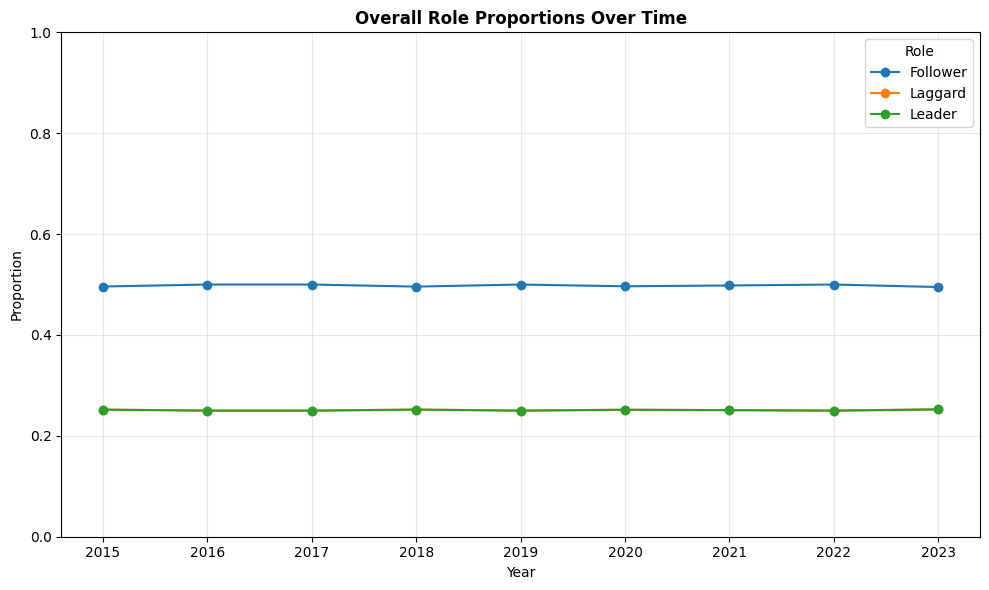

✅ Overall trend plot saved to: E:\Waterloo-onedrive\OneDrive - University of Waterloo\MSE 641\Trend Analysis\overall_role_trend.png


In [ ]:
# Plotting the overall trend of each  over time

import pandas as pd
import matplotlib.pyplot as plt
import os

trend_dir = r"E:\Waterloo-onedrive\OneDrive - University of Waterloo\MSE 641\Trend Analysis"

pivot_overall = overall.pivot(index='year', columns='role', values='prop').fillna(0)

plt.figure(figsize=(10, 6))
for role in pivot_overall.columns:
    plt.plot(pivot_overall.index, pivot_overall[role], marker='o', label=role)

plt.title('Overall Role Proportions Over Time', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.ylim(0, 1)  
plt.legend(title='Role', loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()

out_path = os.path.join(trend_dir, 'overall_role_trend.png')
plt.savefig(out_path, dpi=300)
plt.show()
print(f"Overall trend plot saved to: {out_path}")


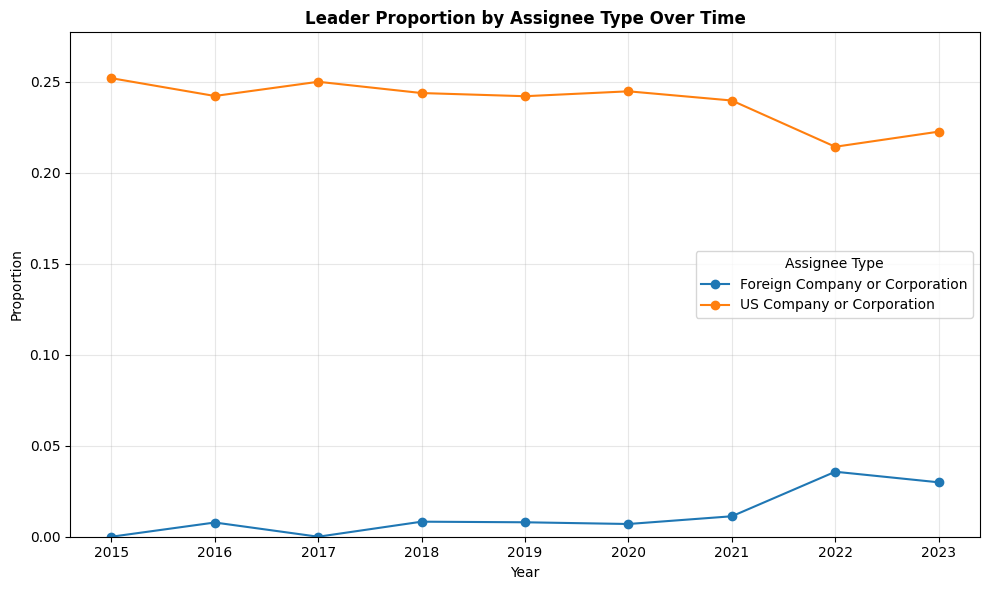

✅ Leader trend plot saved to: E:\Waterloo-onedrive\OneDrive - University of Waterloo\MSE 641\Trend Analysis\leader_trend_by_type.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Assignee type mapping
assignee_map = {
    1: 'Unassigned',
    2: 'US Company or Corporation',
    3: 'Foreign Company or Corporation',
    4: 'US Individual',
    5: 'Foreign Individual',
    6: 'US Federal Government',
    7: 'Foreign Government',
    8: 'US County Government',
    9: 'US State Government'
}



# 1. Leader
leaders = type_trend[type_trend['role']=='Leader'].copy()


leaders['assignee_label'] = leaders['assignee_type'].map(assignee_map)

pivot_leader = leaders.pivot(
    index='year',
    columns='assignee_label',
    values='prop'
).fillna(0)

plt.figure(figsize=(10, 6))
for label in pivot_leader.columns:
    plt.plot(pivot_leader.index, pivot_leader[label], marker='o', label=label)

plt.title('Leader Proportion by Assignee Type Over Time', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.ylim(0, pivot_leader.values.max() * 1.1)
plt.legend(title='Assignee Type', loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()

out_path2 = os.path.join(trend_dir, 'leader_trend_by_type.png')
plt.savefig(out_path2, dpi=300)
plt.show()
print(f"Leader trend plot saved to: {out_path2}")


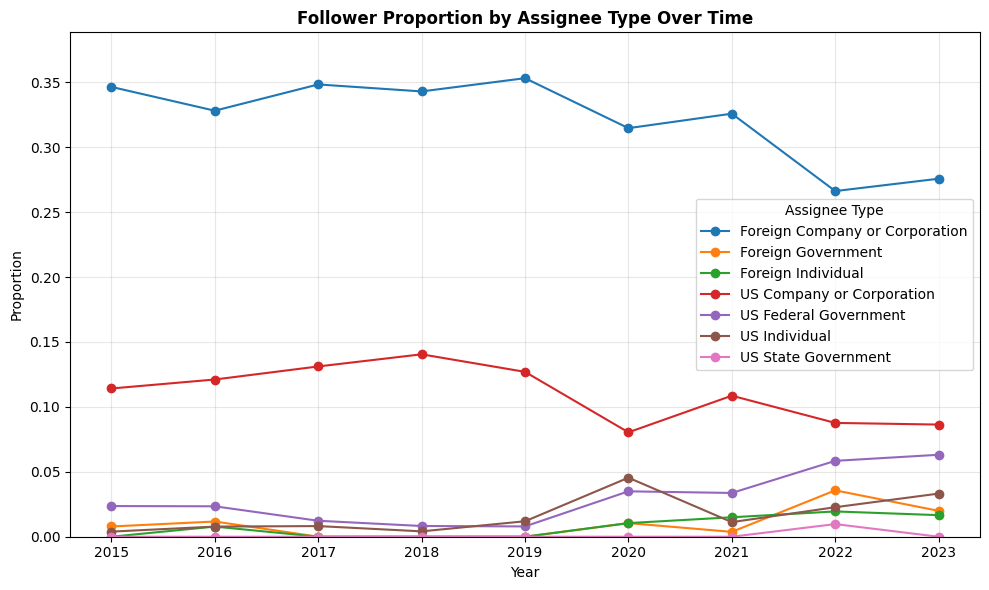

✅ Follower trend plot saved to: E:\Waterloo-onedrive\OneDrive - University of Waterloo\MSE 641\Trend Analysis\follower_trend_by_type.png


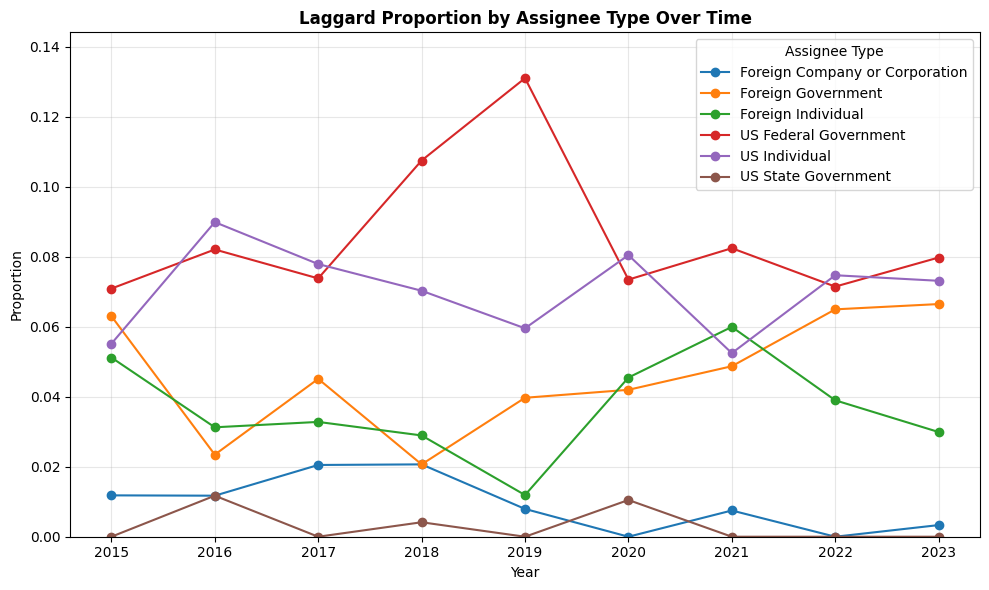

✅ Laggard trend plot saved to: E:\Waterloo-onedrive\OneDrive - University of Waterloo\MSE 641\Trend Analysis\laggard_trend_by_type.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Assignee type mapping
assignee_map = {
    1: 'Unassigned',
    2: 'US Company or Corporation',
    3: 'Foreign Company or Corporation',
    4: 'US Individual',
    5: 'Foreign Individual',
    6: 'US Federal Government',
    7: 'Foreign Government',
    8: 'US County Government',
    9: 'US State Government'
}

# Follower
followers = type_trend[type_trend['role'] == 'Follower'].copy()
followers['assignee_label'] = followers['assignee_type'].map(assignee_map)

pivot_follower = followers.pivot(
    index='year',
    columns='assignee_label',
    values='prop'
).fillna(0)

plt.figure(figsize=(10, 6))
for label in pivot_follower.columns:
    plt.plot(pivot_follower.index, pivot_follower[label], marker='o', label=label)

plt.title('Follower Proportion by Assignee Type Over Time', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.ylim(0, pivot_follower.values.max() * 1.1)
plt.legend(title='Assignee Type', loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()

out_path_f = os.path.join(trend_dir, 'follower_trend_by_type.png')
plt.savefig(out_path_f, dpi=300)
plt.show()
print(f"Follower trend plot saved to: {out_path_f}")

#Laggard
laggards = type_trend[type_trend['role'] == 'Laggard'].copy()
laggards['assignee_label'] = laggards['assignee_type'].map(assignee_map)

pivot_laggard = laggards.pivot(
    index='year',
    columns='assignee_label',
    values='prop'
).fillna(0)

plt.figure(figsize=(10, 6))
for label in pivot_laggard.columns:
    plt.plot(pivot_laggard.index, pivot_laggard[label], marker='o', label=label)

plt.title('Laggard Proportion by Assignee Type Over Time', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.ylim(0, pivot_laggard.values.max() * 1.1)
plt.legend(title='Assignee Type', loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()

out_path_l = os.path.join(trend_dir, 'laggard_trend_by_type.png')
plt.savefig(out_path_l, dpi=300)
plt.show()
print(f"Laggard trend plot saved to: {out_path_l}")
